In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('/Users/celty/Desktop/data_set_hackathon.csv')

In [3]:
# Drop duplicates
df.drop_duplicates(inplace=True)

In [4]:
# No null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2417 entries, 0 to 2419
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_date               2417 non-null   object 
 1   requested_delivery_date  2417 non-null   object 
 2   Customer Country Code    2417 non-null   object 
 3   Product Code             2417 non-null   object 
 4   Description              2417 non-null   object 
 5   order_type               2417 non-null   object 
 6   Customer Order Code      2417 non-null   int64  
 7   value                    2417 non-null   float64
 8   Curr                     2417 non-null   object 
 9   items                    2417 non-null   object 
 10  Route                    2417 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 226.6+ KB


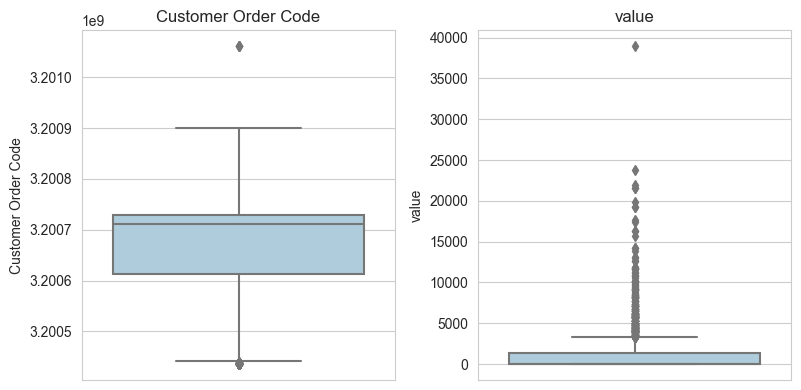

In [5]:
# Check outliers
sns.set_style("whitegrid")
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

n = len(numeric_cols)
ncols = 5
nrows = n // ncols + (1 if n % ncols else 0)

plt.figure(figsize=(20, nrows * 4))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(nrows, ncols, i)
    sns.boxplot(y=df[col],palette='Paired')
    plt.title(col)
    plt.tight_layout()

plt.show()

In [6]:
# Drop outliers
outlier_index = df['value'].idxmax()
df.drop(outlier_index, inplace=True)


In [7]:
# Check negative values that do not make sense.
numeric_cols = df.select_dtypes(include=['float64', 'int64'])
rows_with_negative_values = numeric_cols[numeric_cols.lt(0).any(axis=1)]
rows_with_negative_values
df = df.drop(rows_with_negative_values.index)

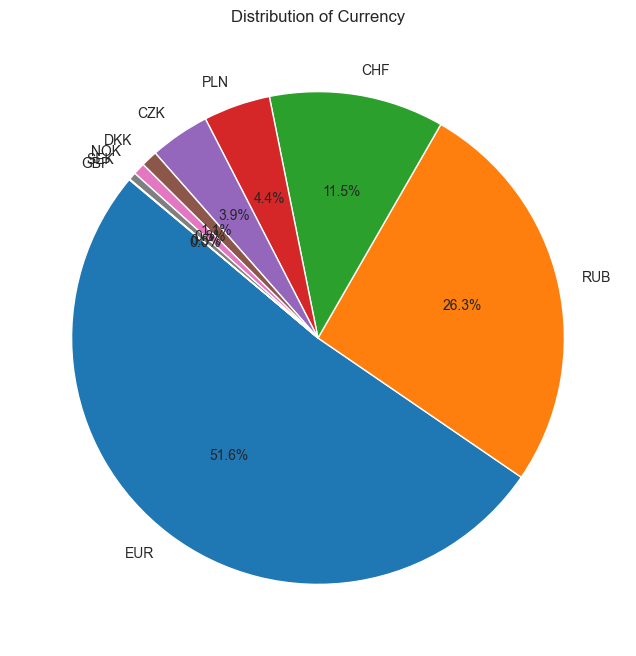

In [8]:
# Analyzing and visualizing the distribution of 'Currency' using a pie chart

# Counting the occurrences of each currency
currency_counts = df['Curr'].value_counts()

# Creating a pie chart for the distribution of currencies
plt.figure(figsize=(8, 8))
plt.pie(currency_counts, labels=currency_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Currency')
plt.show()

EUR occupied around 50% of the sales, we decide to change all currency into EUR. The order value is generated into value_EUR.

In [9]:
# Currency Exchange.
currencies_to_convert = ['RUB', 'DKK', 'NOK', 'CHF', 'SEK', 'CZK', 'PLN', 'GBP']

# Fetching the current exchange rates for these currencies against EUR
exchange_rates = {
    "RUB": 0.010,
    "DKK": 0.13,
    "NOK": 0.85,
    "CHF": 1.06,
    "SEK": 0.09,
    "CZK": 0.04,
    "PLN": 0.23,
    "GBP": 1.17
}

exchange_rates["EUR"] = 1.0

# Convert the value to EUR and update the dataframe
for index, row in df.iterrows():
    currency = row['Curr']
    value = row['value']
    
    # Convert the value to EUR
    if currency in exchange_rates:
        converted_value = value * exchange_rates[currency]
        df.at[index, 'value'] = converted_value
        df.at[index, 'Curr'] = 'EUR'

In [10]:
# Fill in ['items'] & ['value'], create ['price']
df1 = df.copy()
# Convert 'items' column to numeric
df1['items'] = pd.to_numeric(df1['items'], errors='coerce')

# Drop rows where 'items' or 'value' is NaN, as we can't calculate price for these
df1.dropna(subset=['items'], inplace=True)

df1['order_date'] = pd.to_datetime(df1['order_date'])
df1['requested_delivery_date'] = pd.to_datetime(df1['requested_delivery_date'])

df1['value_EUR'] = df1.apply(lambda row: row['value'] * exchange_rates[row['Curr']], axis=1)
df1['Price'] = df1['value_EUR'] / df1['items']
df1['Year'] = df1['requested_delivery_date'].dt.year
df1['Month'] = df1['requested_delivery_date'].dt.month
df1['Year'] = df1['Year'].astype('object')
df1['Month'] = df1['Month'].astype('object')

unit_price = df1.groupby(['Product Code','Year','Month'])['Price'].mean()
avg_order_value = df1.groupby(['Product Code','Year','Month'])['value_EUR'].median()
df['items'] = pd.to_numeric(df['items'], errors='coerce')
df['order_date'] = pd.to_datetime(df['order_date'])
df['requested_delivery_date'] = pd.to_datetime(df['requested_delivery_date'])

label_encoder = LabelEncoder()
df['Product_Code_Encoded'] = label_encoder.fit_transform(df['Product Code'])
df['value_EUR'] = df.apply(lambda row: row['value'] * exchange_rates[row['Curr']], axis=1)


df['Year'] = df['requested_delivery_date'].dt.year
df['Month'] = df['requested_delivery_date'].dt.month

df.sort_values('requested_delivery_date', inplace=True)

# Function to apply the median value where 'items' is NaN
def apply_median_value(row, median_values):
    if pd.isna(row['items']):
        product_code = row['Product Code']
        year = row['Year']
        month = row['Month']
        median_value = median_values.get((product_code, year, month))
        if median_value is not None:
            return median_value
    return row['value_EUR']

# Applying the function to the DataFrame
df['value_EUR'] = df.apply(lambda row: apply_median_value(row, avg_order_value), axis=1)

df['Price'] = df['value_EUR'] / df['items']

/var/folders/05/d9ht8d1s3rs1ny1n4s1z1_zc0000gn/T/ipykernel_15537/956076012.py:9: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df1['order_date'] = pd.to_datetime(df1['order_date'])
/var/folders/05/d9ht8d1s3rs1ny1n4s1z1_zc0000gn/T/ipykernel_15537/956076012.py:10: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df1['requested_delivery_date'] = pd.to_datetime(df1['requested_delivery_date'])
/var/folders/05/d9ht8d1s3rs1ny1n4s1z1_zc0000gn/T/ipykernel_15537/956076012.py:22: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['order_date'] = pd.to_datetime(df['order_date'])
/var/folders/05/d9ht8d1s3rs1ny1n4s1z1_zc0000gn/T/ipykernel_15537/956076012.py:23

In [11]:
def apply_mean_price(row, price):
    if pd.isna(row['items']):
        product_code = row['Product Code']
        year = row['Year']
        month = row['Month']
        median_value = price.get((product_code, year, month))
        if median_value is not None:
            return median_value
    return row['Price']

df['Price'] = df.apply(lambda row: apply_mean_price(row, unit_price), axis=1)
df['items'] = np.where(df['items'].isnull(), 
                       df['value_EUR'] / df['Price'], 
                       df['items'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2415 entries, 0 to 2027
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_date               2415 non-null   datetime64[ns]
 1   requested_delivery_date  2415 non-null   datetime64[ns]
 2   Customer Country Code    2415 non-null   object        
 3   Product Code             2415 non-null   object        
 4   Description              2415 non-null   object        
 5   order_type               2415 non-null   object        
 6   Customer Order Code      2415 non-null   int64         
 7   value                    2415 non-null   float64       
 8   Curr                     2415 non-null   object        
 9   items                    2405 non-null   float64       
 10  Route                    2415 non-null   object        
 11  Product_Code_Encoded     2415 non-null   int64         
 12  value_EUR                2415 non-null 

In [13]:
df.dropna(subset=['items', 'Price'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2405 entries, 0 to 2027
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_date               2405 non-null   datetime64[ns]
 1   requested_delivery_date  2405 non-null   datetime64[ns]
 2   Customer Country Code    2405 non-null   object        
 3   Product Code             2405 non-null   object        
 4   Description              2405 non-null   object        
 5   order_type               2405 non-null   object        
 6   Customer Order Code      2405 non-null   int64         
 7   value                    2405 non-null   float64       
 8   Curr                     2405 non-null   object        
 9   items                    2405 non-null   float64       
 10  Route                    2405 non-null   object        
 11  Product_Code_Encoded     2405 non-null   int64         
 12  value_EUR                2405 non-null 

In [14]:
df['Processing Time'] = (df['requested_delivery_date'] - df['order_date']).dt.days
df['Advance Demand'] = df.apply(lambda row: row['items'] if row['Processing Time'] > 30 else 0, axis=1)
df = df[df['Processing Time'] >= 0]

### EDA

 #### 1. univariate analysis

In [15]:
# Create a list of numeric columns for univariate analysis

numeric_columns = ['order_date','requested_delivery_date','value','items',
                   'Product_Code_Encoded','Price','Advance Demand']

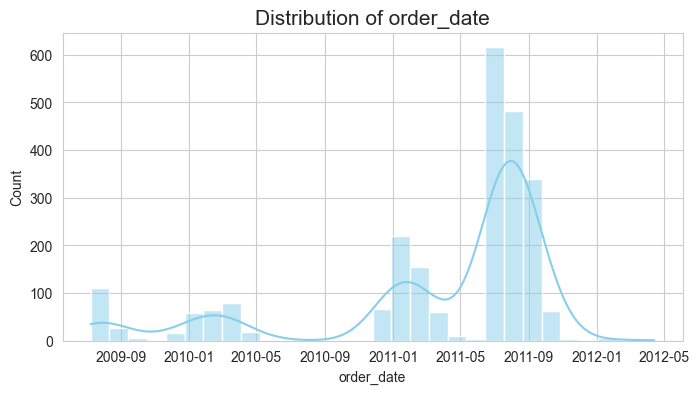

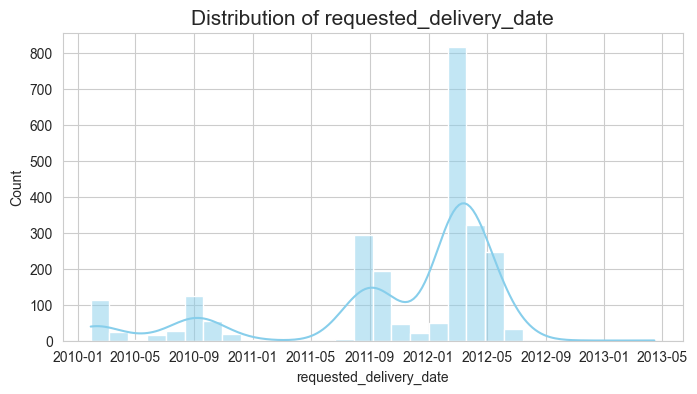

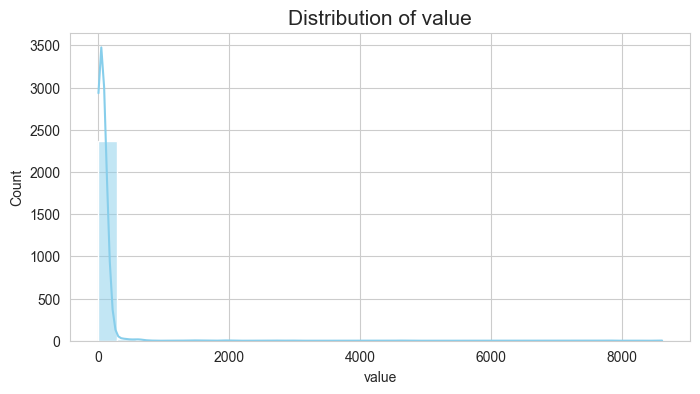

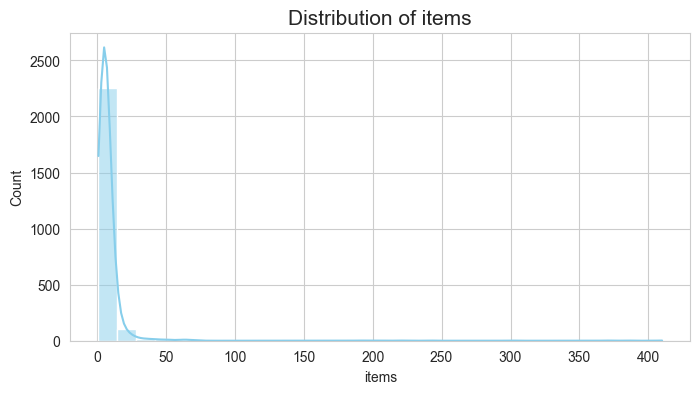

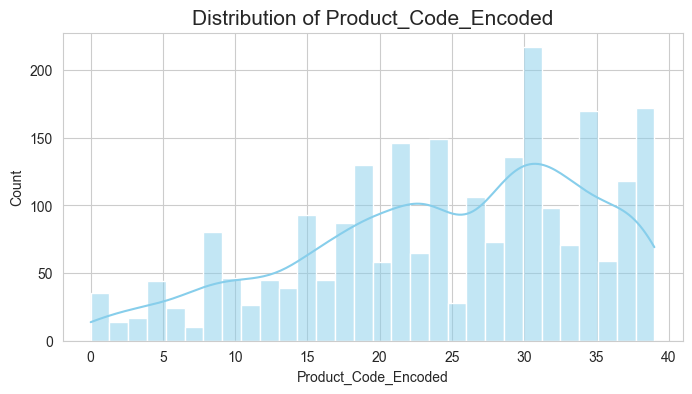

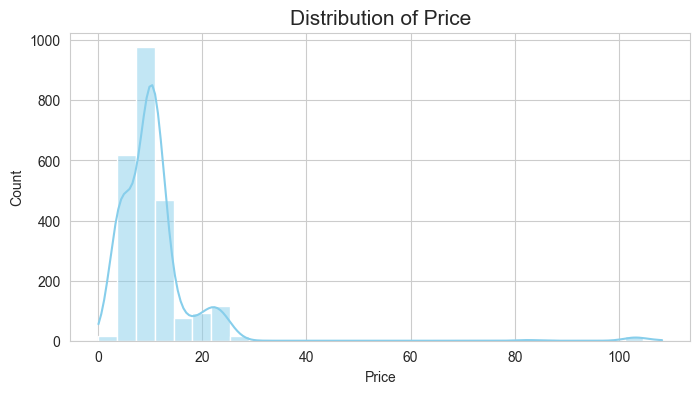

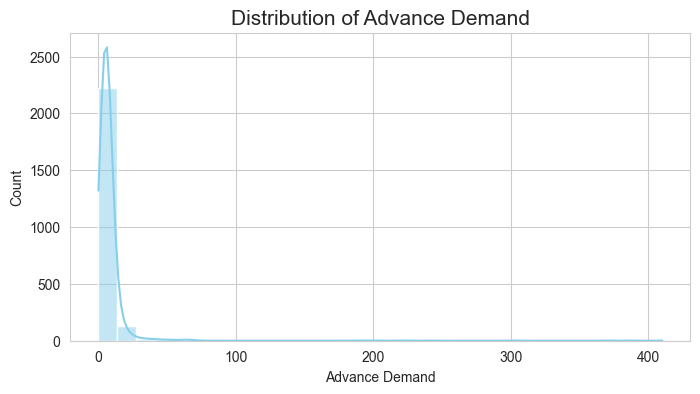

In [16]:
# Plot histograms for numeric columns

for column in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=column, kde=True, color='skyblue', bins=30)
    plt.title(f'Distribution of {column}', fontsize=15)
    plt.show()

Order_ The number of dates in July 2011 is the highest, and the proportion of quantities with 0 in value, items, and advanced demand is the highest

<Figure size 2000x2000 with 0 Axes>

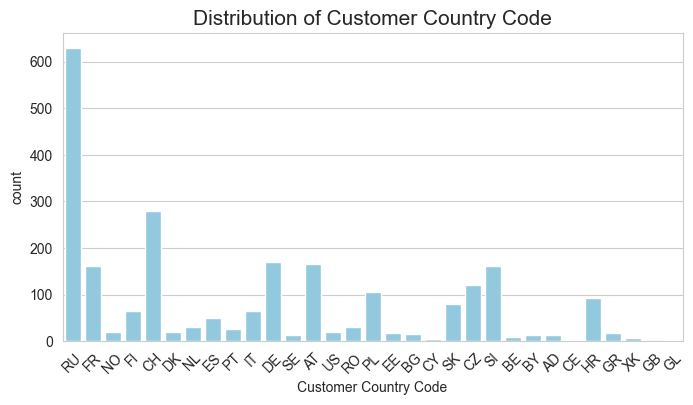

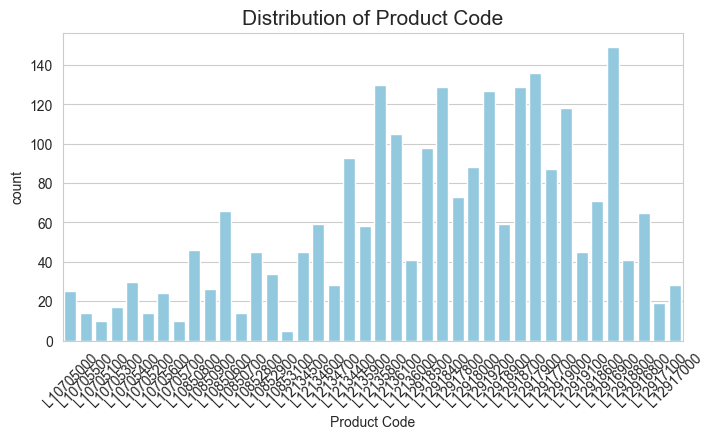

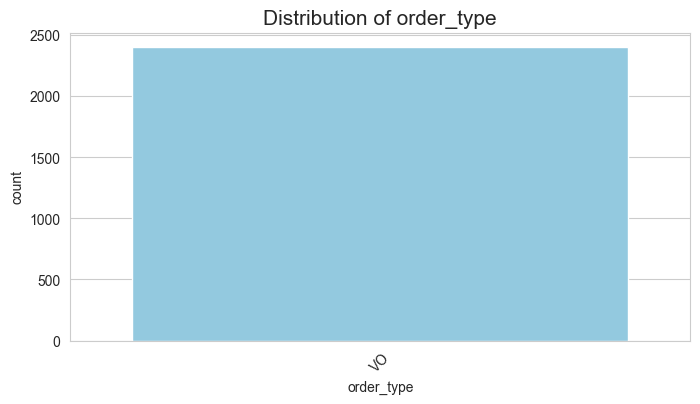

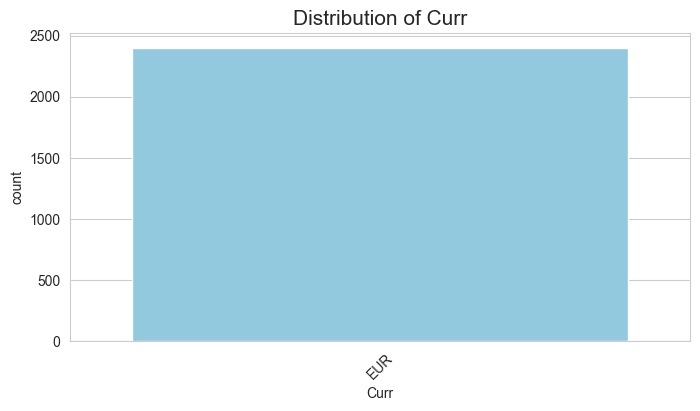

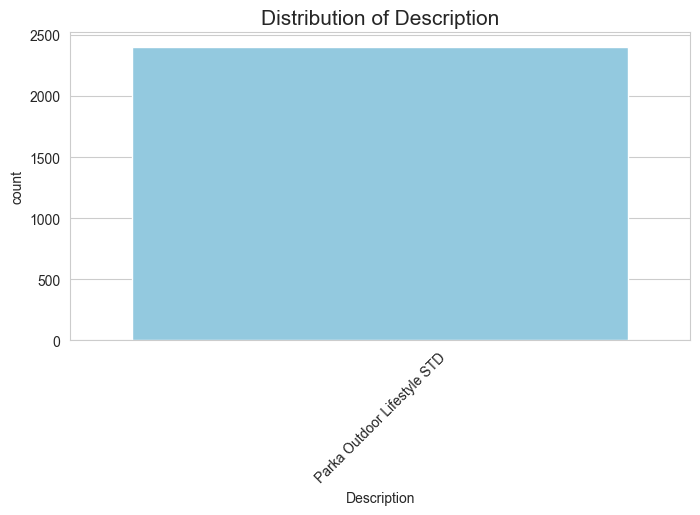

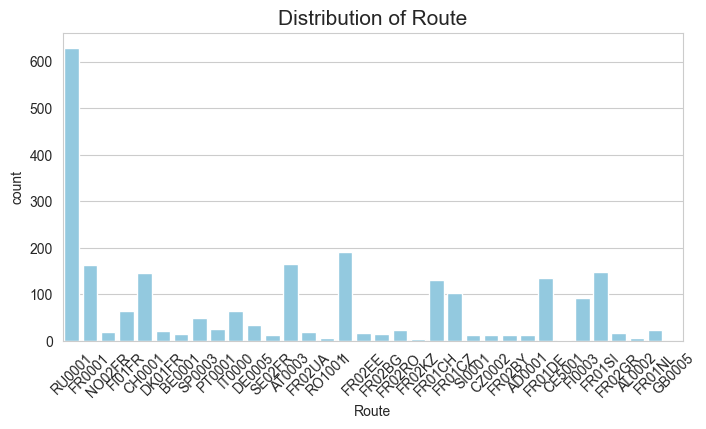

In [17]:
# Create a figure instance and set the figure size
fig = plt.figure(figsize=(20, 20))

# List of categorical columns
categorical_columns = ['Customer Country Code','Product Code','order_type','Curr',
                      'Description','Route']

# Plot bar charts for categorical columns
for column in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=column, color='skyblue')
    plt.title(f'Distribution of {column}', fontsize=15)
    plt.xticks(rotation=45)
    plt.show()

RU has the highest proportion in the customer country, with over 80% of products in the product code exceeding 20. There is only one VO in the order type, and only EUR in the currency. In the description, only Parka Outdoor Lifestyle STD is available

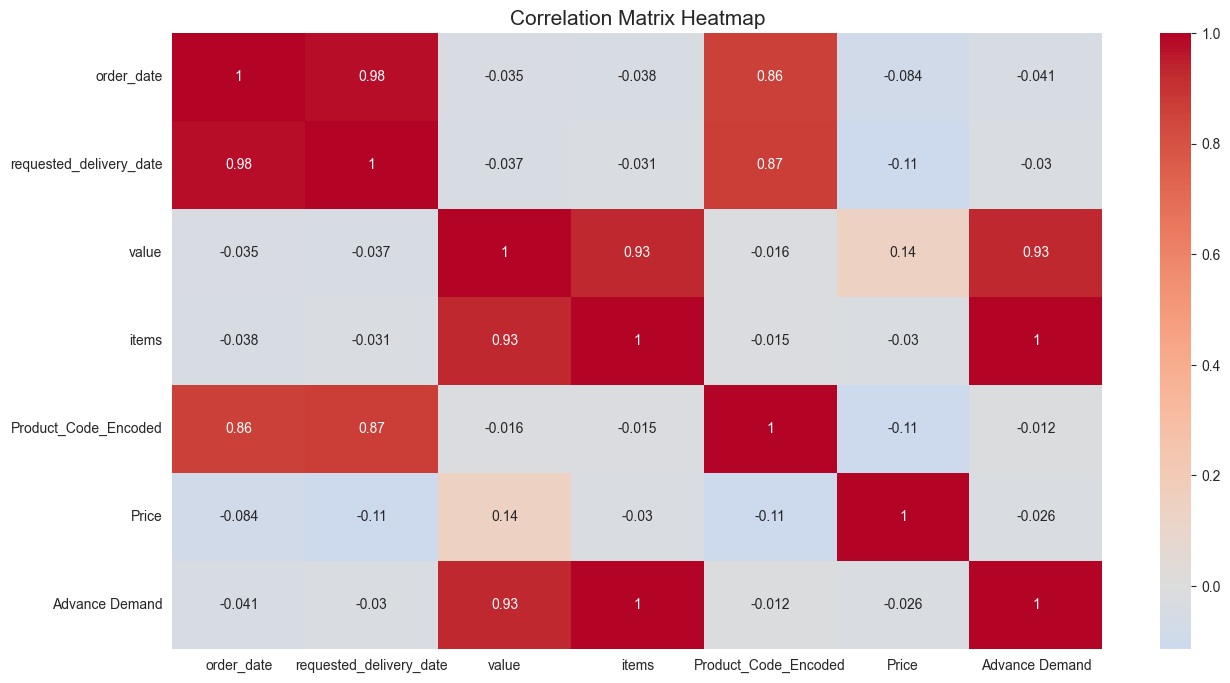

In [18]:
# Correlation among numerical variables

corr = df[numeric_columns].corr()

plt.figure(figsize=(15, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap', fontsize=15)
plt.show()

In the correlation, except for the highest correlation between items and advanced demand, there is no multicollinearity among other variables

#### 2. multivariate analysis

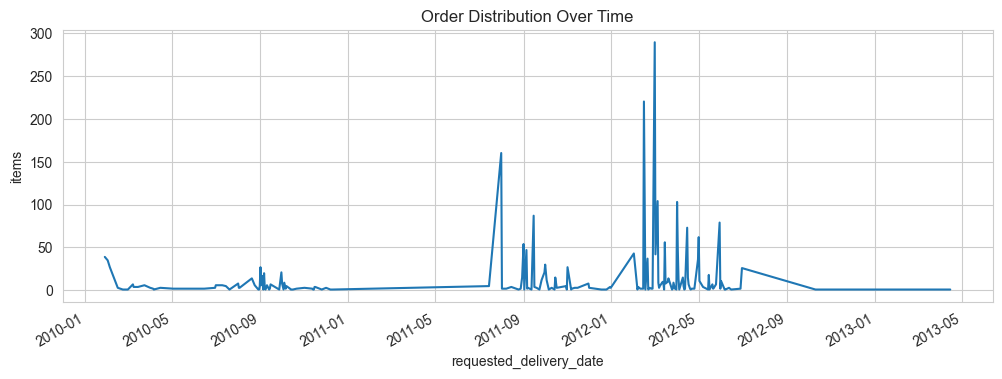

In [19]:
# Check the distribution of orders over time
plt.figure(figsize=(12, 4))
df['requested_delivery_date'].value_counts().sort_index().plot(kind='line')
plt.title('Order Distribution Over Time')
plt.xlabel('requested_delivery_date')
plt.ylabel('items')
plt.show()

For items, during September 2011 and 2012, the quantity fluctuated significantly, with most of the remaining time being below 50

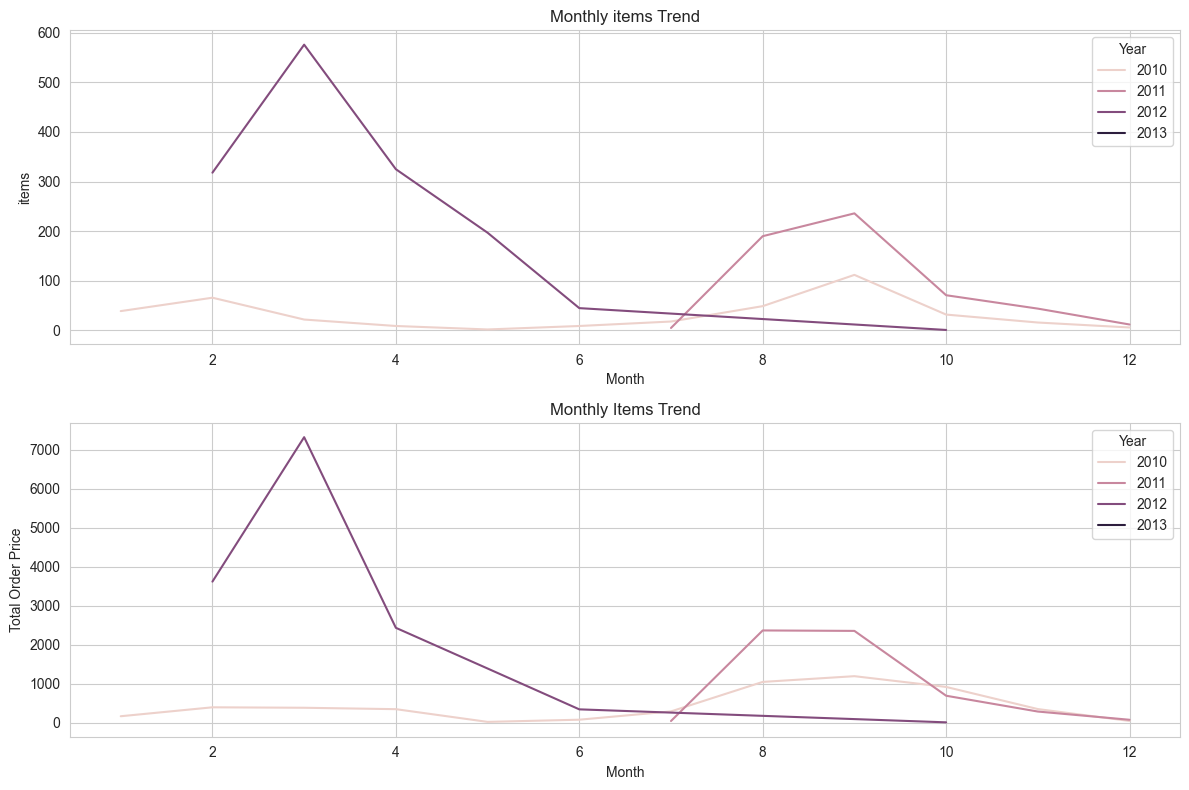

In [20]:
# Analyze seasonal patterns in order frequency and value

df['Year'] = df['requested_delivery_date'].dt.year
df['Month'] = df['requested_delivery_date'].dt.month
# Monthly trend analysis
monthly_orders = df.groupby(['Year', 'Month']).size().reset_index(name='items')
monthly_order_value = df.groupby(['Year', 'Month'])['Price'].sum().reset_index(name='Total Order Price')

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

sns.lineplot(x="Month", y="items", hue="Year", data=monthly_orders, ax=ax[0])
ax[0].set_title('Monthly items Trend')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('items')

sns.lineplot(x="Month", y="Total Order Price", hue="Year", data=monthly_order_value, ax=ax[1])
ax[1].set_title('Monthly Items Trend')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Total Order Price')

plt.tight_layout()
plt.show()

In month, items reached their peak in spring in 2012, while in autumn in 2010 and 2011, items reached their peak, showing the opposite level in quantity compared to 2012

<Figure size 10000x5000 with 0 Axes>

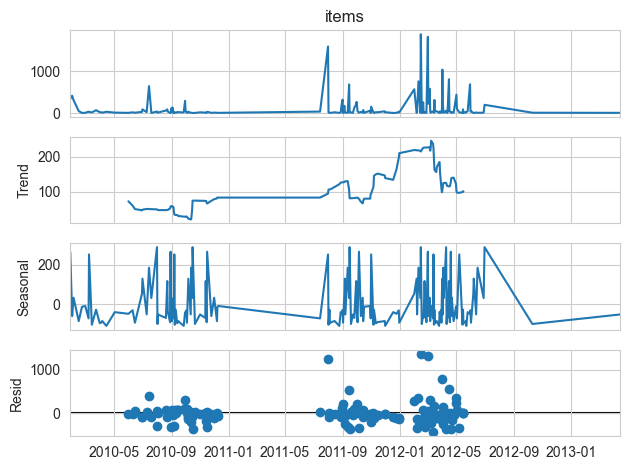

In [21]:
# Aggregating data by order date
ts_data2 = df.groupby('requested_delivery_date')['items'].sum()

# Performing seasonal decomposition
# Assuming monthly seasonality; frequency is set to 30 (approximate number of days in a month)
decomposition = seasonal_decompose(ts_data2, model='additive', period=30)

plt.figure(figsize=(100, 50))
fig = decomposition.plot()
plt.show()

As for seasonality, overall, items fluctuated significantly in the first half of the year and remained relatively stable in the middle

/var/folders/05/d9ht8d1s3rs1ny1n4s1z1_zc0000gn/T/ipykernel_15537/3712738588.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='Month', y='items', hue='Product Code', ci=None)


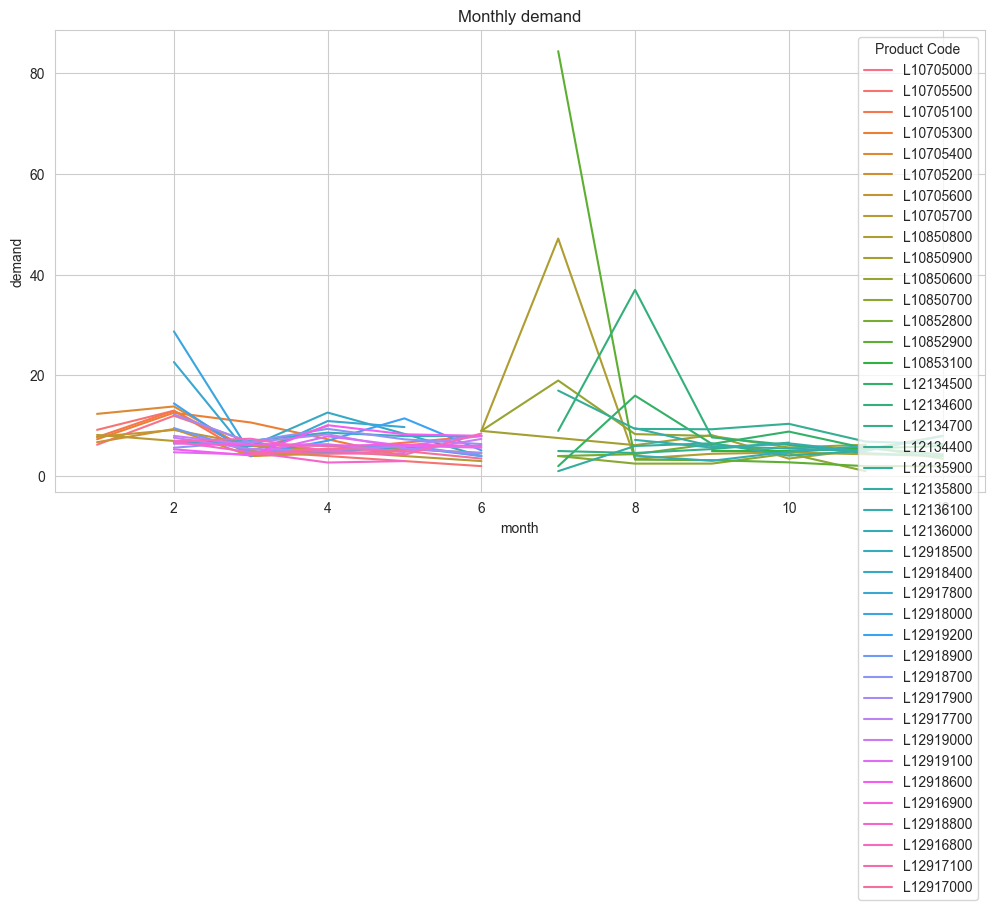

In [22]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Month', y='items', hue='Product Code', ci=None)
plt.title('Monthly demand')
plt.xlabel('month')
plt.ylabel('demand')
plt.show()

For monthly demand, there is relatively little demand for some products between February and April. During June and August, the demand for two of these products reached their peak, even exceeding 80%

### Demand model depending on the advance orders 

In [23]:
# aggregated monthly demand
monthly_demand = df.groupby(['Year','Month']).agg({'items': 'sum', 'Advance Demand': 'sum'})
monthly_demand = monthly_demand.rename(columns={'items': 'Demand'})
monthly_demand

Demand  Advance Demand
Year Month                             
2010 1       338.000000      338.000000
     2       766.085769      766.085769
     3       144.000000      144.000000
     4        71.000000       71.000000
     5         9.000000        9.000000
     6        54.000000       54.000000
     7       750.000000      750.000000
     8       258.543899      258.543899
     9       677.660435      677.660435
     10      150.000000      150.000000
     11       81.000000       81.000000
     12       27.000000       27.000000
2011 7        34.000000       34.000000
     8      1854.925413     1695.925413
     9      1562.354629     1502.354629
     10      486.753884      486.753884
     11      241.068925      241.068925
     12       65.000000       65.000000
2012 2      3530.456381     3530.456381
     3      3271.727402     3271.727402
     4      2699.281352     2699.281352
     5      1461.795007     1461.795007
     6       270.235606      270.235606
     10        7.000000        7.000000
2013 4         4.000000        4.000000

Since the model has only one or two independent variables (pre-order demand and demand from the previous month), multicollinearity may not be a major concern. OLS (Ordinary Least Squares) is typically effective enough for such a simple linear relationship.

In [24]:
Y = np.array(monthly_demand['Demand'][1:])

X = np.array([monthly_demand['Demand'][:-1],
              monthly_demand['Advance Demand'][1:]
              ]).T
X = sm.add_constant(X)

L = np.array(monthly_demand['Advance Demand'][1:])


beta = np.linalg.inv(X.T @ X) @ X.T @ Y

lam = np.dot(2*(np.linalg.pinv(np.dot(np.dot(X,np.linalg.pinv(np.dot(X.T,X))),X.T))), L) - 2* Y
lam[lam < 0] = 0
beta_reg = np.dot(np.linalg.pinv(np.dot(X.T, X)), np.dot(X.T, Y) + 0.5*np.dot(lam, X))

pred = np.dot(X, beta)
pred_reg = np.dot(X, beta_reg)
pred_reg[np.argwhere(lam > 0)] = L[np.argwhere(lam > 0)]


mse_ols = mean_squared_error(Y, pred)
mse_reg = mean_squared_error(Y, pred_reg)

print(f"OLS MSE: {mse_ols}")
print(f"Reg MSE: {mse_reg}")

OLS MSE: 990.0810273971059
Reg MSE: 976.1412080437361


The "Reg" model demonstrates a slightly improved performance over the OLS model, with a lower Mean Squared Error (MSE) suggesting a tighter fit to the observed data, which could indicate a more accurate predictive model.

In [25]:
Y - pred_reg

array([-13.63812703,  -1.08676392,  -6.31316102,  -6.21476482,
        -7.43192573, -16.25376301,  -2.77269373, -13.25209491,
        -2.0477844 ,  -6.3865677 ,  -6.35486835,  -6.98618062,
       129.94788195,  51.67052379,   2.28232798,  -5.16302664,
        -5.26601242, -53.17789575,   0.        ,   0.        ,
         0.        ,   4.16418508,  -4.20286461,  -6.78588936])

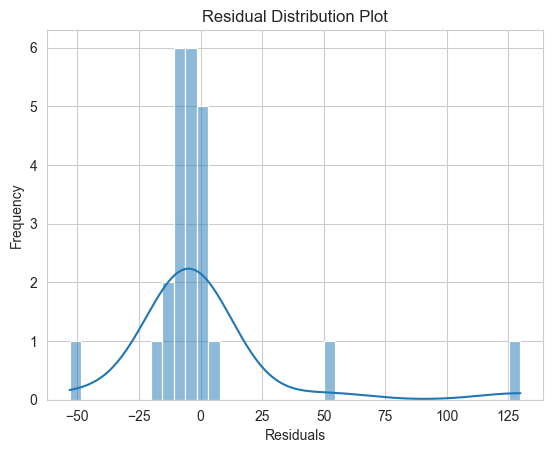

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have 'residuals' as your residual values
residuals = Y - pred_reg

# Create a residual distribution plot
sns.histplot(residuals, kde=True)
plt.title('Residual Distribution Plot')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


In the plot, most of the residuals are concentrated around zero, but there are a few outliers, especially in the positive range of the residuals. This plot shows a great performance of this model.

### Choice Model

In [27]:
sku_demand = df.groupby(['Year', 'Month','Product Code'])['items'].sum().reset_index(name='Demand')

sku_demand['Probability'] = sku_demand.apply(lambda row: row['Demand'] / monthly_demand.loc[(row['Year'], row['Month']),'Demand'], axis=1)


sku_demand

,Year,Month,Product Code,Demand,Probability
0,2010,1,L10705000,25.000000,0.073964
1,2010,1,L10705100,31.000000,0.091716
2,2010,1,L10705200,27.000000,0.079882
3,2010,1,L10705300,22.000000,0.065089
4,2010,1,L10705400,99.000000,0.292899
...,...,...,...,...,...
188,2012,6,L12919000,44.421628,0.164381
189,2012,6,L12919100,17.000000,0.062908
190,2012,6,L12919200,20.555153,0.076064
191,2012,10,L12136000,7.000000,1.000000


In [28]:
average_price = df.groupby(['Year', 'Month', 'Product Code'])['Price'].mean()

# Move the average price forward one month as the expected price for the next month
expected_price = average_price.groupby(level='Product Code').shift(1)

# Add the calculated expected price to the original data set
# Here you need to merge the original data set and expected price data
sku_demand = sku_demand.merge(expected_price.rename('Expected Price'), 
                              on=['Year', 'Month', 'Product Code'], 
                              how='left')

sku_demand.head()

,Year,Month,Product Code,Demand,Probability,Expected Price
0,2010,1,L10705000,25.0,0.073964,NaN
1,2010,1,L10705100,31.0,0.091716,NaN
2,2010,1,L10705200,27.0,0.079882,NaN
3,2010,1,L10705300,22.0,0.065089,NaN
4,2010,1,L10705400,99.0,0.292899,NaN


In [29]:
pd.set_option('display.max_rows', None)
sku_demand.head()

,Year,Month,Product Code,Demand,Probability,Expected Price
0,2010,1,L10705000,25.0,0.073964,NaN
1,2010,1,L10705100,31.0,0.091716,NaN
2,2010,1,L10705200,27.0,0.079882,NaN
3,2010,1,L10705300,22.0,0.065089,NaN
4,2010,1,L10705400,99.0,0.292899,NaN


In [30]:
sku_demand['Expected Price'] = sku_demand.groupby('Product Code')['Expected Price'].fillna(method='bfill')
sku_demand.head()

,Year,Month,Product Code,Demand,Probability,Expected Price
0,2010,1,L10705000,25.0,0.073964,4.126563
1,2010,1,L10705100,31.0,0.091716,4.108750
2,2010,1,L10705200,27.0,0.079882,4.180000
3,2010,1,L10705300,22.0,0.065089,4.203750
4,2010,1,L10705400,99.0,0.292899,4.236406


In [31]:
missing_values = sku_demand.isnull().sum()
missing_values

Year              0
Month             0
Product Code      0
Demand            0
Probability       0
Expected Price    0
dtype: int64

In [32]:
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

# Preparing the data for logistic regression
X = df.drop(['Product Code', 'items', 'value', 'Description'], axis=1)  # Features
y = df['Product Code']  # Target

# Handling categorical and numerical variables
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Pipeline for data transformation
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a logistic regression pipeline
logreg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', LogisticRegression(multi_class='multinomial'))])

# Fit the logistic regression model
logreg_pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = logreg_pipeline.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
report

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

'              precision    recall  f1-score   support\n\n   L10705000       1.00      0.67      0.80         9\n   L10705100       0.00      0.00      0.00         2\n   L10705200       0.00      0.00      0.00         4\n   L10705300       0.00      0.00      0.00         7\n   L10705400       0.11      0.50      0.18         6\n   L10705500       0.00      0.00      0.00         4\n   L10705600       0.12      0.20      0.15         5\n   L10705700       0.00      0.00      0.00         3\n   L10850600       0.44      0.52      0.48        21\n   L10850700       0.00      0.00      0.00         4\n   L10850800       0.67      0.62      0.65        16\n   L10850900       1.00      0.11      0.20         9\n   L10852800       0.37      0.39      0.38        18\n   L10852900       0.33      0.44      0.38         9\n   L10853100       0.00      0.00      0.00         2\n   L12134400       0.51      0.90      0.65        29\n   L12134500       0.33      0.08      0.12        13\n   L121

This dataset has a too complex ecology, therefore, a 41% of accuracy presents a good performance of the model.

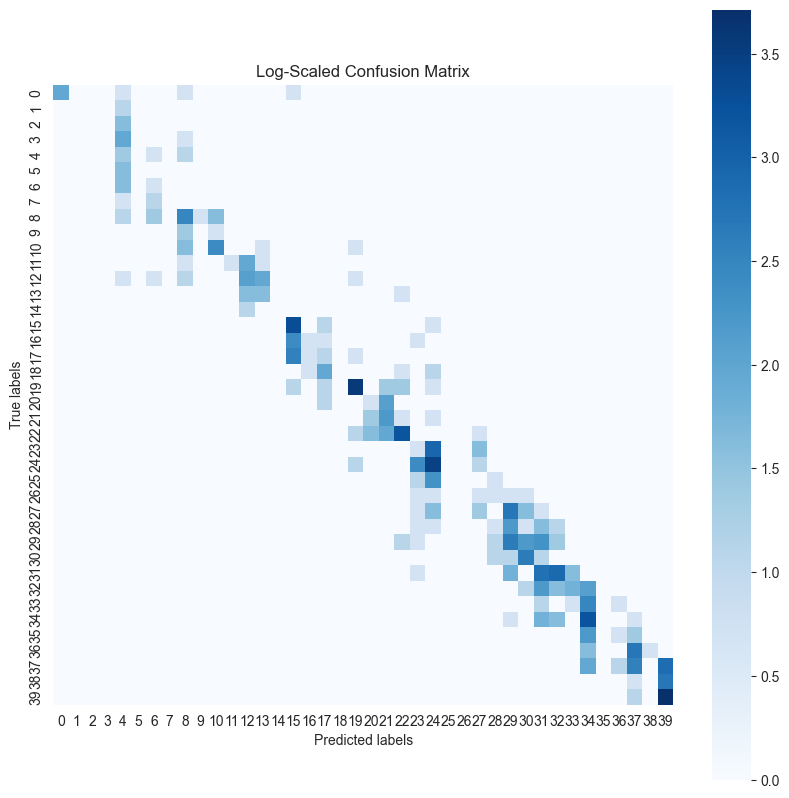

In [34]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
log_conf_matrix = np.log(conf_matrix + 1)

import seaborn as sns

plt.figure(figsize=(10, 10))
sns.heatmap(log_conf_matrix, cmap='Blues', cbar=True, square=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Log-Scaled Confusion Matrix')
plt.show()

This confusion matrix displays a diagonal line, which indicates strong performance in predictions.

In [35]:
# Function to determine the season based on the month
def map_date_to_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'
    elif month in [12, 1, 2]:
        return 'winter'

In [36]:
# Add season information to X_test (similar to how it was added to the whole dataset)
X_test['Season'] = pd.to_datetime(X_test['requested_delivery_date']).dt.month.apply(map_date_to_season)

# Predict probabilities
probabilities = logreg_pipeline.predict_proba(X_test)

class_labels=df['Product Code'].unique()
# Convert probabilities to a DataFrame
probabilities_df = pd.DataFrame(probabilities, columns=class_labels)

# Combine with X_test for grouping
combined_df = pd.concat([X_test.reset_index(drop=True), probabilities_df], axis=1)

# Group by season and calculate average probabilities for each product
seasonal_probabilities = combined_df.groupby('Season')[class_labels].mean()

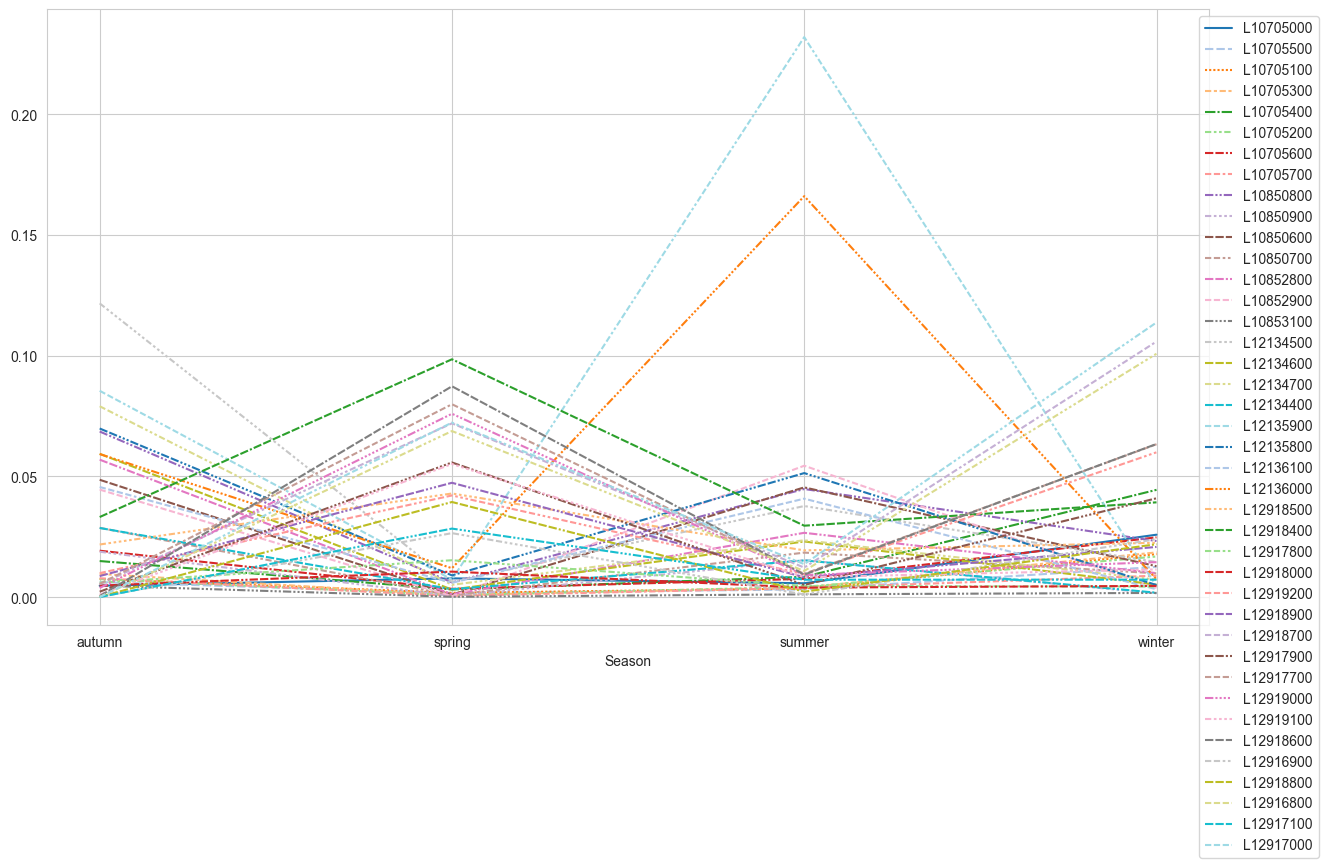

In [37]:
plt.figure(figsize=(15, 8))
sns.lineplot(data=seasonal_probabilities, palette='tab20')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.0))  # You can adjust the position as needed

plt.show()

1. Data Cleaning

First, convert all items to their respective numeric types. Next, address missing values in both the sales value and items fields. These gaps will be filled using the median values derived from order values, given their non-normally distributed nature. Additionally, calculate the item counts based on the sales value divided by the average unit price within the corresponding year, month, and product code. Extract the year and month from the 'requested_delivery_date' field. Finally, ensure data cleanliness by removing negative values, duplicates, and outliers.

2. Feature Engineering

To align with the currency of EUR, a new column labeled "value_EUR" is generated. Additionally, a "Processing Time" column is created to calculate the duration between the order date and the requested delivery date. Furthermore, a binary variable, "Advance Demand," is introduced to classify orders; orders with processing times exceeding 30 days are categorized as advance demand.

3. EDA

Univariate analysis of all numerical columns:

● Order_ The number of dates in July 2011 is the highest, and the proportion of quantities with 0 in value, items, and advanced demand is the highest.

● Univariate analysis categorical columns.

● RU has the highest proportion in the customer country, with over 80% of products in the
product code exceeding 20. There is only one VO in the order type, and only EUR in the
currency. In the description, only Parka Outdoor Lifestyle STD is available.

● In the correlation, except for the highest correlation between items and advanced demand,
there is no multicollinearity among other variables. 

Multivariate analysis of graphical situations:

● For items, during September 2011 and 2012, the quantity fluctuated significantly, with most
of the remaining time being below 50.

● In a month, items reached their peak in spring in 2012, while in autumn in 2010 and 2011,
items reached their peak, showing the opposite level in quantity compared to 2012.

● As for seasonality, overall, items fluctuated significantly in the first half of the year and remained relatively stable in the middle.

● For monthly demand, there is relatively little demand for some products between February
and April. During June and August, the demand for two of these products reached their peak, even exceeding 80%

4. Demand Model

The Demand Model is constructed using data on the previous month's demand and advance demand, compiling an aggregated monthly demand dataset spanning from 2009 to 2013. The model leverages Ordinary Least Squares (OLS) and regularized regression methodologies to forecast demand. In the OLS approach, regression coefficients are derived by inverting a matrix with the np.linalg.inv() function, while the regularized regression employs a lambda (lam)
parameter to fine-tune the coefficients, adding a penalty to the model to avoid overfitting. Finally, the performance of the OLS model is evaluated against the regularized model by comparing the Mean Squared Error (MSE) results of both, allowing for an assessment of prediction accuracy and model robustness.

5. Probability Model

The Probability Model is constructed utilizing variables such as "Year," "Month," "Product Code," and "Expected Price" to analyze the seasonality and price impact on product demand. To facilitate this, an aggregated table is created where each product's price is determined by averaging the prices from the preceding month. In the data preprocessing phase, techniques such as standard scaling and one-hot encoding are employed to structure the data suitably for the model. The dataset is then divided into training and testing sets with a 70/30 split. A logistic regression model is integrated into the pipeline as the classification method to forecast product types. Additionally, this model is used to calculate the choice probabilities, which assist the company in identifying the periods of higher or lower demand for each product on a monthly basis.

6. Final Result

● Demand Model MSE: The Demand Model's performance, as measured by the Mean Squared
Error (MSE), reveals that the regularized regression model, with an MSE of 976.1412, slightly outperforms the Ordinary Least Squares (OLS) model, which has an MSE of 990.0810. This indicates that the regularized model may be a more accurate predictor. Additionally, the residuals of the model predominantly fall within the range of -20 to 10, further demonstrating the precision of the model's results.

● Confusion Matrix: The confusion matrix displays a diagonal line, indicating strong performance in predictions. Most of the predictions match the actual product labels since they are primarily located on the diagonal line within the matrix.

● Seasonality Plot by Product Types: This plot illustrates the seasonality demands of various products. It is evident that a series of products experience higher demand during the summer season, with the top demands being for L12135900 and L12136000. L12134500 sees increased demand in autumn, while L1291700 is more sought after in winter. In spring, the most demanded products are L12918400 and L12918600.

7. Conclusion:

Both models have demonstrated exceptional predictive performance. The demand model has significantly enhanced the accuracy of monthly total demand predictions and aids the company in gauging the need for advance orders. Meanwhile, the choice model optimizes the probabilities of each item across the four seasons, effectively addressing the impact of seasonality on product demand. This valuable insight enables the company to improve demand and purchase management practices, thereby reducing excessive inventory costs, handling fees, and sales losses due to product shortages. These improvements have a substantial impact on the company's revenue management.